# Tutorial

In [1]:
%matplotlib inline
import capital as cp
import scanpy as sc

## Preprocessing scRNA-seq data
Read a count matrix (cells x genes) of your own data as an AnnData object using sc.read().

In [2]:
#adata1 = sc.read("./your_data1.h5ad")

Run a simple preproccesing recipe.

In [3]:
#cp.tl.preprocessing(adata1, n_Top_genes=2000, K=40)

Specifically, cp.tl.preprocessing() runs a simple preprocessing recipe as follows:

```
sc.pp.filter_cells(adata, min_genes=Min_Genes)
sc.pp.filter_genes(adata, min_cells=Min_Cells)
sc.pp.normalize_total(adata, exclude_highly_expressed=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=Min_Mean, max_mean=Max_Mean, min_disp=Min_Disp, n_top_genes=n_Top_genes)
adata.raw = adata
adata = adata[:,adata.var['highly_variable']]
sc.tl.pca(adata, n_comps=N_pcs)
sc.pp.neighbors(adata, n_neighbors=K, n_pcs=N_pcs)
sc.tl.diffmap(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.tl.paga(adata, groups='leiden')
```

In this tutorial, we will use two datasets that have already been preprocessed.  
Download might take a minute.

In [4]:
adata1 = cp.dataset.setty19()

setty19_capital.h5ad: 0.00B [00:00, ?B/s]Downloading the dataset.
setty19_capital.h5ad: 351MB [01:58, 2.96MB/s]                           
Download completed. The dataset is saved in ../data/capital_dataset/setty19_capital.h5ad


In [5]:
adata1

AnnData object with n_obs × n_vars = 5780 × 1999
    obs: 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

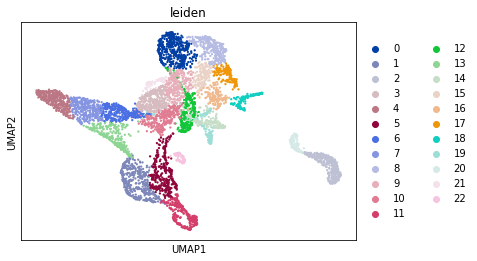

In [6]:
sc.pl.umap(adata1, color="leiden")

Note that dataset 2 will be loaded later.

## Computing a trajectory tree with CAPITAL
Pass the AnnData object and the root name in the trajectory to cp.tl.trajectory_tree().  
You can pass your metadata in adata.obs by choosing a key in adata.obs.  
You can also draw your own defined tree in networkx.DiGraph and pass it to the argument.

In [7]:
cp.tl.trajectory_tree(adata1, root_node="4", groupby="leiden", tree=None)

Draw the calculated tree.

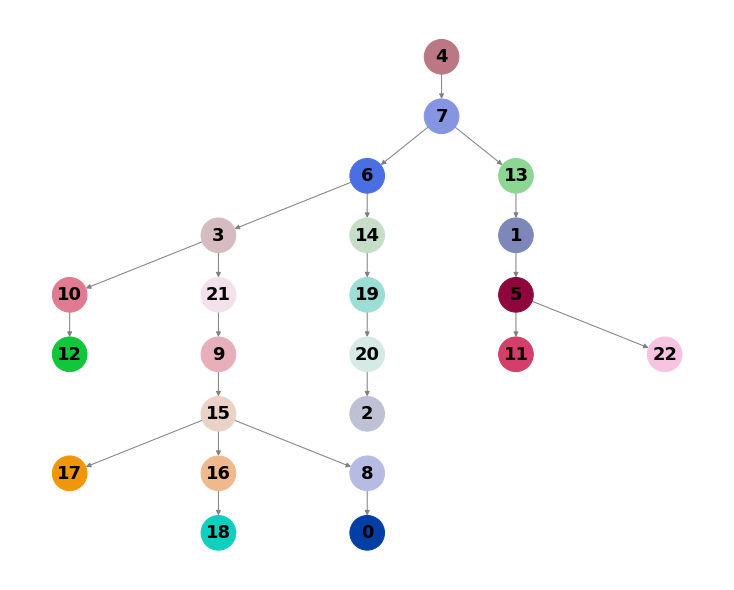

In [8]:
cp.pl.trajectory_tree(adata1)

Apply the same process to one or more datasets that you would like to align.

In [9]:
adata2 = cp.dataset.velten17()

velten17_capital.h5ad: 0.00B [00:00, ?B/s]Downloading the dataset.
velten17_capital.h5ad: 41.9MB [00:13, 3.20MB/s]                            
Download completed. The dataset is saved in ../data/capital_dataset/velten17_capital.h5ad


In [10]:
adata2

AnnData object with n_obs × n_vars = 915 × 249
    obs: 'n_genes', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

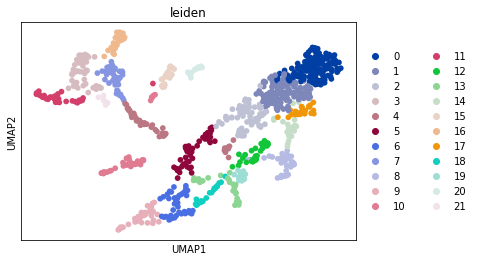

In [11]:
sc.pl.umap(adata2, color="leiden")

In [12]:
cp.tl.trajectory_tree(adata2, root_node="0", groupby="leiden", tree=None)

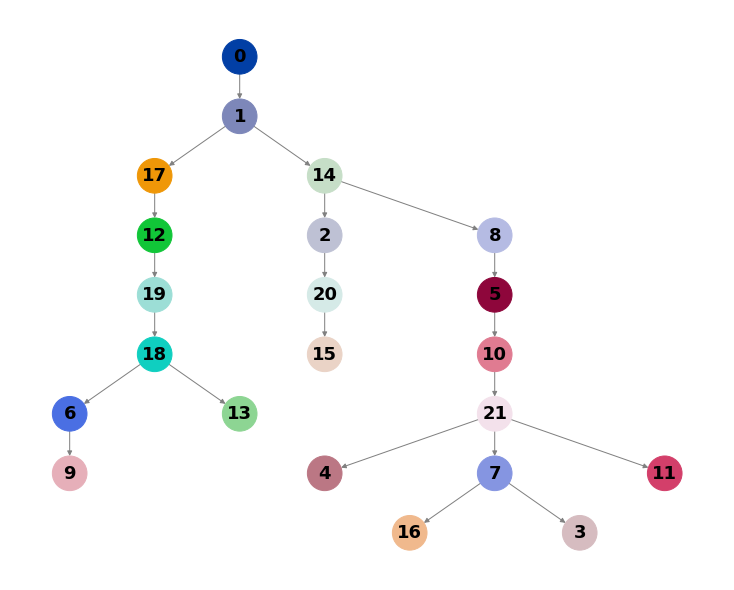

In [13]:
cp.pl.trajectory_tree(adata2)

## Aligning trajectory trees with CAPITAL
The alignment of trajectory trees is calculated by minimizing an alignment distance.
<!--
described in [our paper](https://www.biorxiv.org/content/10.1101/859751v1).
-->
You can specify the number of highly variable genes for both of the data so that the intersection of those genes is used to calculate the tree alignment.

In [14]:
cdata = cp.tl.tree_alignment(adata1, adata2, num_genes1=2000, num_genes2=2000)

Calculating tree alignment
411 genes are used to calculate cost of tree alignment.

Calculation finished.


Draw the tree alignment result.

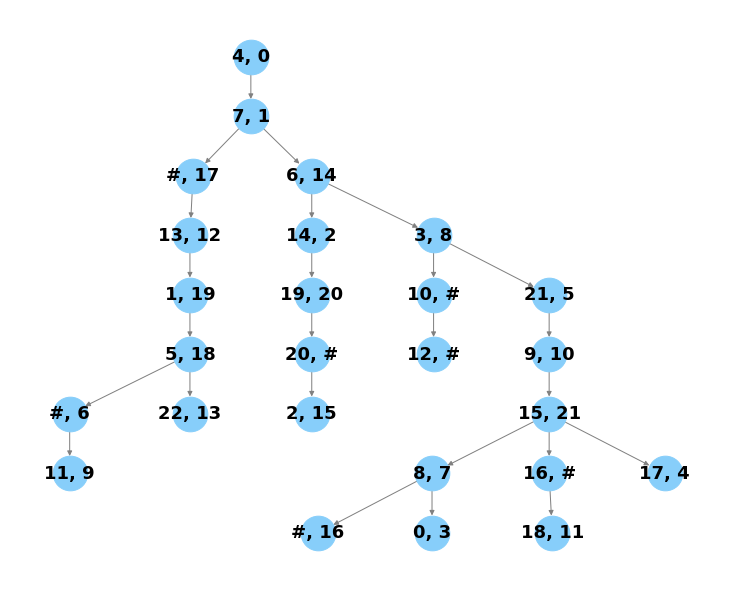

In [15]:
cp.pl.tree_alignment(cdata)

Each linear alignment from the root to each leaf (path) is labeled as alignmentXYZ where X, Y and Z indicate digit.  
See the list of the alignments name by alignmentlist.

In [16]:
cdata.alignmentlist

[('alignment000',
  ['4', '7', '#', '13', '1', '5', '22'],
  ['0', '1', '17', '12', '19', '18', '13']),
 ('alignment001',
  ['4', '7', '#', '13', '1', '5', '#', '11'],
  ['0', '1', '17', '12', '19', '18', '6', '9']),
 ('alignment002',
  ['4', '7', '6', '14', '19', '20', '2'],
  ['0', '1', '14', '2', '20', '#', '15']),
 ('alignment003',
  ['4', '7', '6', '3', '10', '12'],
  ['0', '1', '14', '8', '#', '#']),
 ('alignment004',
  ['4', '7', '6', '3', '21', '9', '15', '8', '#'],
  ['0', '1', '14', '8', '5', '10', '21', '7', '16']),
 ('alignment005',
  ['4', '7', '6', '3', '21', '9', '15', '8', '0'],
  ['0', '1', '14', '8', '5', '10', '21', '7', '3']),
 ('alignment006',
  ['4', '7', '6', '3', '21', '9', '15', '16', '18'],
  ['0', '1', '14', '8', '5', '10', '21', '#', '11']),
 ('alignment007',
  ['4', '7', '6', '3', '21', '9', '15', '17'],
  ['0', '1', '14', '8', '5', '10', '21', '4'])]

## Aligning cells along each trajectory path
Run dpt (diffusion pseudotime) to calculate pseudotime for each alignment.  
Specify the alignment name (list of alignment names) to choose which path should be compared to calculate cell-cell matching.  
Note: calculating pseudotime for all the alignments might take for a minute.

In [17]:
cp.tl.dpt(cdata, alignment=["alignment001", "alignment002"])

Choose genes to do dynamic time warping.

In [18]:
genes = ["GATA1", "CA1", "LMNA"]

In [19]:
cp.tl.dtw(cdata, genes, alignment="alignment001")

Draw the result of dynamic time warping.  
The colors in the labels correspond to the colors of sc.pl.umap().

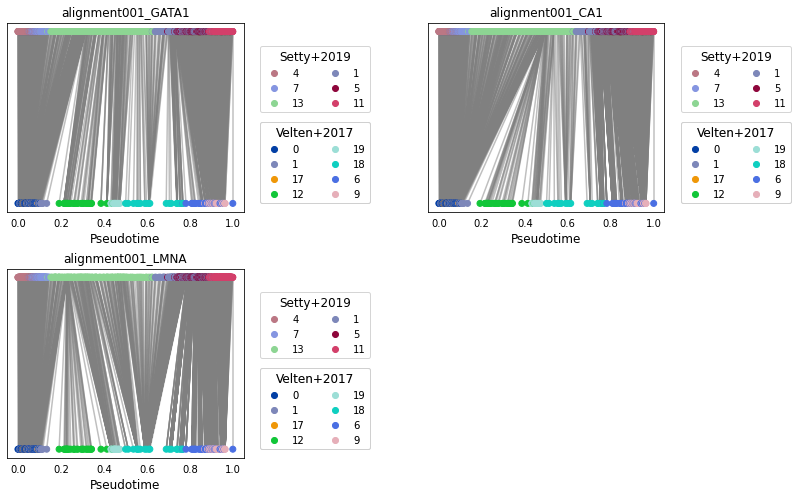

In [20]:
cp.pl.dtw(cdata, genes, alignment="alignment001", 
          data1_name="Setty+2019", data2_name="Velten+2017")

Draw gene expression dynamics for both data.  
Pseudotime in this figure is matched to adata1's pseudotime.

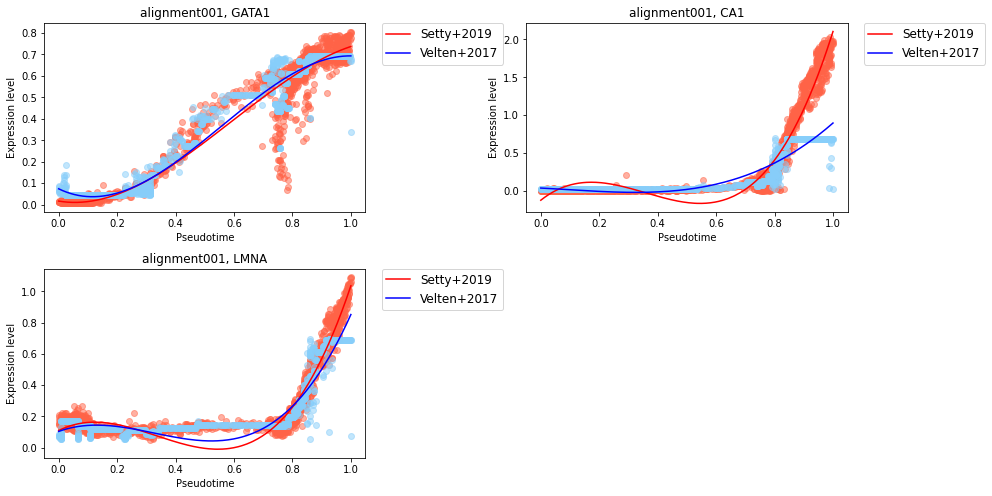

In [21]:
cp.pl.gene_expression_trend(cdata, genes, alignment="alignment001", 
                            data1_name="Setty+2019", data2_name="Velten+2017")

## Writing CAPITAL results
Specify a directory so that two AnnData objects, adata1 and adata2, and capital_data.npz are saved in the directory.  
You can read CAPITAL data by passing the directory path to cp.tl.read_capital_data().

In [22]:
cdata.write("../results/cdata")

In [23]:
cdata = cp.tl.read_capital_data("../results/cdata")

## Calculating similarity scores of genes in cell-cell alignment
Computing dynamic time warping for each gene will generate a similarity score (see [here](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw_path.html#tslearn.metrics.dtw_path) for details).  
You can pass a value to min_disp to choose how many genes are used to calculate the score.  
The genes that have larger normalized dispersions per gene than min_disp in either data are chosen.  
Results are in cdata.similarity_score.  
The higher in the resulting list, the more similar the gene expression trend is.

In [24]:
cp.tl.genes_similarity_score(cdata, alignment="alignment002", min_disp=0.5)

Calculating similarity score of 5148 genes in alignment002
Calculating finished


In [25]:
cdata.similarity_score["alignment002"]

array(['TROAP', 'DBI', 'BLOC1S1', ..., 'ARPP21', 'FCRL1', 'NBEAL1'],
      dtype=object)

See gene expression trends that have similar trends in the alignment.

In [26]:
high_similarlity_genes = cdata.similarity_score["alignment002"][:4]

In [27]:
cp.tl.dtw(cdata, high_similarlity_genes, alignment="alignment002")

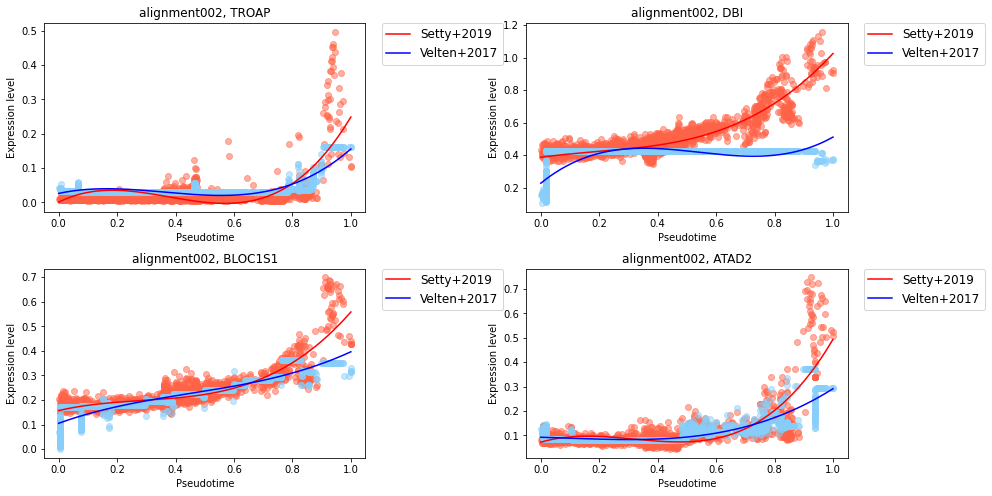

In [28]:
cp.pl.gene_expression_trend(cdata, high_similarlity_genes, alignment="alignment002", 
                            data1_name="Setty+2019", data2_name="Velten+2017")

See also gene expression trends that have lower similarlity score in the alignment.

In [29]:
low_similarlity_genes = cdata.similarity_score["alignment002"][::-1][:4]

In [30]:
cp.tl.dtw(cdata, low_similarlity_genes, alignment="alignment002")

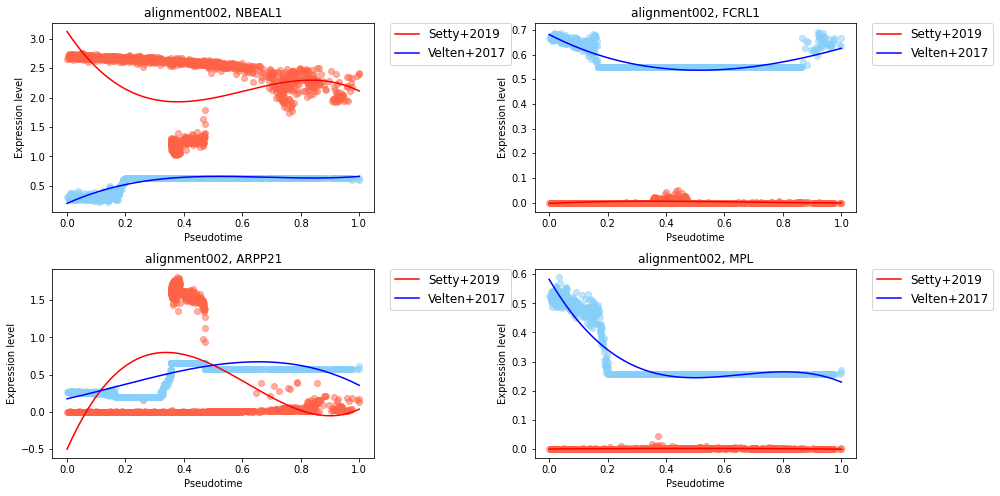

In [31]:
cp.pl.gene_expression_trend(cdata, low_similarlity_genes, alignment="alignment002", 
                            data1_name="Setty+2019", data2_name="Velten+2017")